
### 1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>. You have to use data.csv file for this assignment
### 2. Code the model to classify data like below image. You can use any number of units in your Dense layers.

<img src='https://i.imgur.com/33ptOFy.png'>



# <font color='red'> <b>3. Writing Callbacks </b> </font>
## You have to implement the following callbacks
-  Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.Do not use tf.keras.metrics for calculating AUC and F1 score.

- Save your model at every epoch if your validation accuracy is improved from previous epoch. 

- You have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.
        
- If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 

- You have to stop the training if your validation accuracy is not increased in last 2 epochs.

- Use tensorboard for every model and analyse your scalar plots and histograms. (you need to upload the screenshots and write the observations for each model for evaluation)



##Data Preprocessing

In [96]:
# from google.colab import drive
# drive.mount('/content/drive')

In [97]:
# import pandas as pd
# path = "/content/drive/MyDrive/Named_Assignments/Callbacks/data.csv"
# data = pd.read_csv(path)
# data.head()

If you are running this noteboook in local machine Comment the above two cells and uncomment the below cell. 

In [99]:
import pandas as pd
path_local = "/Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/data.csv"
data = pd.read_csv(path_local)
data.head()

,f1,f2,label
0,0.450564,1.074305,0.0
1,0.085632,0.967682,0.0
2,0.117326,0.971521,1.0
3,0.982179,-0.380408,0.0
4,-0.720352,0.955850,0.0


In [100]:
Y= data['label']
X = data.drop('label',axis =1)
print(X.shape)
print(Y.shape)

(20000, 2)
(20000,)


### Checking for null or nan values

In [101]:
data.isna().sum()

f1       0
f2       0
label    0
dtype: int64

### Splitting data into train and test data

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, stratify = Y, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16000, 2)
(16000,)
(4000, 2)
(4000,)


### Data Normalization

Before we apply data to Neural Networks, we must normalize the data.
Normalizing the data using z-score normalization.

In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train['f1'].values.reshape(-1, 1))

f1_train = scaler.transform(X_train['f1'].values.reshape(-1, 1))
f1_test = scaler.transform(X_test['f1'].values.reshape(-1, 1))
print(f1_train.shape,f1_test.shape)

(16000, 1) (4000, 1)


In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train['f2'].values.reshape(-1, 1))

f2_train = scaler.transform(X_train['f2'].values.reshape(-1, 1))
f2_test = scaler.transform(X_test['f2'].values.reshape(-1, 1))
print(f2_train.shape,f2_test.shape)

(16000, 1) (4000, 1)


### Encoding the output classes into labels rather than float values.

In [105]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train.values)

y_train = encoder.transform(y_train.values)
y_test = encoder.transform(y_test.values)
print(y_train.shape,y_test.shape)
print(y_train[:5])
print(y_test[:5])

(16000,) (4000,)
[1 0 0 1 1]
[1 0 0 1 0]


### Stacking all features

In [106]:
import numpy as np

X_train_ftr = np.hstack((f1_train, f2_train))
X_test_ftr = np.hstack((f1_test, f2_test))
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

print("Final Data matrix")
print(X_train_ftr.shape, y_train.shape)
print(X_test_ftr.shape, y_test.shape)
print("="*100)

Final Data matrix
(16000, 2) (16000, 1)
(4000, 2) (4000, 1)


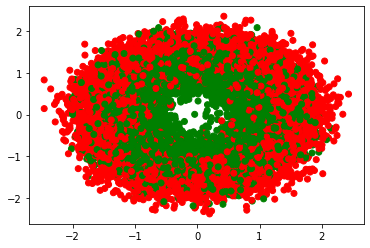

In [107]:
import matplotlib.pyplot as plt
plt.figure()
color= ['red' if l == 0 else 'green' for l in y_train]
plt.scatter(X_train_ftr[:,0],X_train_ftr[:,1],c =color)
plt.show()

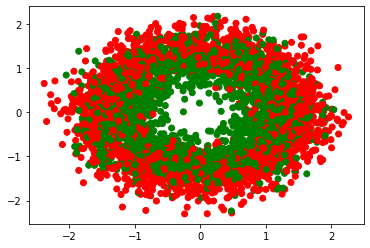

In [108]:
import matplotlib.pyplot as plt
plt.figure()
color= ['red' if l == 0 else 'green' for l in y_test]
plt.scatter(X_test_ftr[:,0],X_test_ftr[:,1],c =color)
plt.show()

**Observation :**
1. This is highly linearly unseparable data in 2D.

## Applying Different models

In [109]:
from tensorflow import keras

def create_model(activation_function, weights_intializer):
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape=(2,),name='input'))
  model.add(keras.layers.Dense(128, activation = activation_function, kernel_initializer= weights_intializer, name='dense_1'))
  model.add(keras.layers.Dense(64, activation = activation_function, kernel_initializer= weights_intializer, name='dense_2'))
  model.add(keras.layers.Dense(32, activation = activation_function, kernel_initializer= weights_intializer, name='dense_3'))
  model.add(keras.layers.Dense(16, activation = activation_function, kernel_initializer= weights_intializer, name='dense_4'))
  model.add(keras.layers.Dense(8, activation = activation_function, kernel_initializer= weights_intializer, name='dense_5'))
  model.add(keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer= weights_intializer, name='output'))

  return model


In [110]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

def fptp(k,y_pred,y_actual):
  cnf_matrix=np.zeros((2,2),dtype=int)    
  y_label = np.array(list(map(lambda y: (1 if y>=k else 0) , y_pred))).reshape((-1,1))
  for i in range(2):
    for j in range(2):
      cnf_matrix[i,j] = sum((y_label==i)&(y_actual == j))
      
  tpr=(cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))
  fpr=(cnf_matrix[1,0]/(cnf_matrix[1,0]+cnf_matrix[0,0]))
  return tpr,fpr
    
def calcfprtpr(x,y_actual):
    tpr_array=[]
    fpr_array=[]    
    for i in x:    
      tpr,fpr=fptp(i[0],x,y_actual)
      tpr_array.append(tpr)
      fpr_array.append(fpr)

    tpr,fpr=fptp(np.max(x)+1,x,y_actual)
    tpr_array.append(tpr)
    fpr_array.append(fpr)

    return tpr_array,fpr_array

def micro_f1_auc(y_pred,y_actual):
  labels = np.unique(y_actual).size
  TP = np.zeros((labels,1))
  FP = np.zeros((labels,1))
  FN = np.zeros((labels,1))
  y_label = np.array(list(map(lambda y: (1 if y>=0.5 else 0) , y_pred))).reshape((-1,1))
    
  for i in range(labels):
    TP[i,0] = sum((y_label == i)&(y_actual == i))
    FP[i,0] = sum((y_label == i)&(y_actual != i))
    FN[i,0] = sum((y_label != i)&(y_actual == i))

  prec=sum(TP)/(sum(TP)+sum(FP))
  recall=sum(TP)/(sum(TP)+sum(FN))
  mu_F1=(2*prec*recall)/(prec+recall)
  # mu_F1 = sum(TP)/(sum(TP)+(0.5*(sum(FP)+sum(FN))))
  mu_F1_Sklearn = f1_score(y_actual, y_label,average='micro')

  print("\nMicro F1 by custom_function is ", mu_F1[0])
  print("Micro F1 by sklearn is", mu_F1_Sklearn)
  # fpr, tpr, thresholds = metrics.roc_curve(y_actual, y_pred, pos_label=1)  

  tpr_array,fpr_array=calcfprtpr(y_pred,y_actual)    
  AUC = np.trapz(sorted(tpr_array), sorted(fpr_array))
  
  # print("Micro F1 score is ", mu_F1)
  # print("AUC by sklearn auc is ",metrics.auc(fpr, tpr))
  print("AUC by sklearn is ",roc_auc_score(y_actual, y_pred))
  print("AUC by custom_function is",AUC)

In [111]:
from tensorflow import keras

class print_f1_auc(keras.callbacks.Callback):
  #custom class for printing the micro f1 score and auc score on end of epoch
  def __init__(self,validation_data):
    self.x = validation_data[0]
    self.y = validation_data[1]    
    super().__init__()  
    
  def on_epoch_end(self, epoch, logs = None):
    model = self.model
    y_pred = model.predict(self.x)     
    micro_f1_auc(y_pred,self.y)



In [112]:
from tensorflow import keras

class model_save(keras.callbacks.Callback):
  #custom class for saving the model if validation accuracy is improved from previous epoch's.
  def __init__(self, filepath):
    super().__init__()
    self.prev_val_acc = 0
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs = None):
    model = self.model
    cur_val_acc = logs['val_binary_accuracy']    
    if(cur_val_acc>self.prev_val_acc):
      # print("\n Current validation accuracy is {0} \n Prev validation accuracy is {1}".format(cur_val_acc,self.prev_val_acc))
      print("saving the model as val_acc > prev_val_acc")      
      model.save(filepath=self.filepath,overwrite=True)
      self.prev_val_acc = cur_val_acc



In [113]:
from tensorflow import keras

def epoch_3_scheduler(epoch,lr):
  if((epoch+1)%3==0):
    print("Setting the learning rate as epoch is multiple of 3")
    lr=0.95*lr
    return lr
  else:
    return lr

class decay_learning(keras.callbacks.Callback):
  #custom class for decaying the learning rate based on conditions.
  def __init__(self):
    super().__init__()
    self.prev_val_acc = 0

  def on_epoch_end(self, epoch, logs = None):
    model = self.model
    cur_val_acc = logs['val_binary_accuracy']      
    lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))

    if(cur_val_acc<self.prev_val_acc):   
      print("Setting the learning rate as val_acc < prev_val_acc")     
      scheduled_lr = lr*0.9
      # Set the value back to the optimizer before new epoch starts
      keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)      
        
    # Call schedule function to get the scheduled learning rate.
    new_lr = epoch_3_scheduler(epoch,lr)
    # Set the value back to the optimizer before new epoch starts
    keras.backend.set_value(self.model.optimizer.lr, new_lr)
    self.prev_val_acc = cur_val_acc




In [114]:
from tensorflow import keras
import numpy as np
# weights 
class stop_train_on_nan(keras.callbacks.Callback):
  #custom class for printing the micro f1 score and auc score on end of epoch
  def __init__(self):
    super().__init__()

  def on_train_batch_end(self, batch, logs = None):
    train_loss = logs['loss']
    weights = self.model.get_weights()
    # print(len(weights))
    if(np.isnan(train_loss)):
      print("found nan values in loss.")
      self.model.stop_training = True
    sam = np.any([np.isnan(np.sum(matrix)) for matrix in weights])
    if(sam):
      print("found nan values in weights or biases")
      self.model.stop_training = True
      


In [115]:
from tensorflow import keras

class stop_train_on_valacc(keras.callbacks.Callback):
  #custom class for printing the micro f1 score and auc score on end of epoch
  def __init__(self,patience):
    super().__init__()
    self.patience = 0
    self.wait = patience
    self.prev_val_acc = 0

  def on_epoch_end(self, epoch, logs = None):
    model = self.model
    cur_val_acc = logs['val_binary_accuracy']
    if(cur_val_acc<=self.prev_val_acc):
      self.patience += 1
      if(self.patience == self.wait):
        # print("\n Current validation accuracy is {0} \n Prev validation accuracy is {1} and patience is {2}".format(cur_val_acc,self.prev_val_acc,self.patience))
        print("Stopping the model Training as val_acc <= prev_val_acc for continuous 2 epochs")      
        self.model.stop_training = True
    else :
      self.patience = 0
    self.prev_val_acc = cur_val_acc
    

<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [116]:
import os
import datetime
from itertools import combinations

In [117]:
path_local = "/Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/"
model_saving_path = os.path.join(path_local,'model_1', "weights")
graph_saving_dir = os.path.join(path_local,'model_1', "Tensorboard_graphs")

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [118]:
# path = "/content/drive/MyDrive/Named_Assignments/Callbacks/"
# model_saving_path = os.path.join(path,'model_1', "weights")
# graph_saving_dir = os.path.join(path,'model_1', "Tensorboard_graphs")

In [119]:
f1_auc_callback = print_f1_auc(validation_data= [X_test_ftr,y_test])
model_save_callback = model_save(model_saving_path)
decay_learning_callback = decay_learning()
patience = 2
stop_train_on_valacc_callback = stop_train_on_valacc(patience)
stop_train_on_nan_callback = stop_train_on_nan()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=graph_saving_dir,histogram_freq=1,write_graph=True)

callbacksList = [f1_auc_callback, model_save_callback, decay_learning_callback, stop_train_on_valacc_callback, stop_train_on_nan_callback, tensorboard_callback]

In [120]:
initializer = keras.initializers.RandomUniform(minval=0, maxval=1)
model = create_model('tanh',initializer)
eta = 0.0001
optimizer = keras.optimizers.SGD(learning_rate=eta,momentum=0.9)
model.compile(optimizer=optimizer,
              metrics = [keras.metrics.BinaryAccuracy()],
              loss=keras.losses.BinaryCrossentropy())
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               384       
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trai

In [122]:
model.fit(X_train_ftr, y_train, epochs = 10,validation_data= (X_test_ftr,y_test), callbacks=[callbacksList])

Epoch 1/10
125/125 [==============================] - 0s 812us/steps: 1.3844 - binary_accuracy: 0.

Micro F1 by custom_function is  0.49225
Micro F1 by sklearn is 0.49225
AUC by sklearn is  0.4921247500000001
AUC by custom_function is 0.49212475000000006
saving the model as val_acc > prev_val_acc
INFO:tensorflow:Assets written to: /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_1/weights/assets
500/500 [==============================] - 72s 143ms/step - loss: 1.3729 - binary_accuracy: 0.5001 - val_loss: 1.0559 - val_binary_accuracy: 0.4922
Epoch 2/10
125/125 [==============================] - 0s 763us/steps: 0.8693 - binary_accuracy: 0.

Micro F1 by custom_function is  0.49225
Micro F1 by sklearn is 0.49225
AUC by sklearn is  0.49263250000000003
AUC by custom_function is 0.49263250000000003
500/500 [==============================] - 72s 145ms/step - loss: 0.8663 - binary_accuracy: 0.5001 - val_loss: 0.7614 - val_binary_accuracy: 0.4922
Epoch 3

In [123]:
# there are other ways of doing this: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/ you can try this way also
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [124]:
%tensorboard --logdir /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_1/Tensorboard_graphs

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [ ]:
# %tensorboard --logdir /content/drive/MyDrive/Named_Assignments/Callbacks/model_1/Tensorboard_graphs

1. The above model stopped as the validation accuracy is same for 2 continuous epochs.
2. As we have intialized the weights with Random uniform(0,1), weight matrices are almost maintaining the same distribution even after some epochs.
3.From weight and bias distributions we can observe that change in the w,b values is very insignificant. 
4. As we have used `tanh` activation function, the updates in weights are insignificant. So we are not getting much improvement in the results. 
4. We have achieved these results
* Micro F1 score - **0.49225**
* Area under the curve, AUC - **0.4926**
* Training Accuracy - **0.5001**
* Validation Accuracy - **0.4922**

<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [152]:
import os
import datetime
from itertools import combinations

In [126]:
path_local = "/Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/"
model_saving_path = os.path.join(path_local,'model_2', "weights")
graph_saving_dir = os.path.join(path_local,'model_2', "Tensorboard_graphs")

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [127]:
# path = "/content/drive/MyDrive/Named_Assignments/Callbacks/"
# model_saving_path = os.path.join(path,'model_2', "weights")
# graph_saving_dir = os.path.join(path,'model_2', "Tensorboard_graphs")

In [128]:
f1_auc_callback = print_f1_auc(validation_data= [X_test_ftr,y_test])
model_save_callback = model_save(model_saving_path)
decay_learning_callback = decay_learning()
patience = 2
stop_train_on_valacc_callback = stop_train_on_valacc(patience)
stop_train_on_nan_callback = stop_train_on_nan()

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=graph_saving_dir,histogram_freq=1,write_graph=True)

callbacksList = [f1_auc_callback, model_save_callback, decay_learning_callback, stop_train_on_valacc_callback, stop_train_on_nan_callback, tensorboard_callback]

In [129]:
initializer = keras.initializers.RandomUniform(minval=0, maxval=1)
model = create_model('relu',initializer)
eta = 0.0001
optimizer = keras.optimizers.SGD(learning_rate=eta,momentum=0.9)
model.compile(optimizer=optimizer,
              metrics = [keras.metrics.BinaryAccuracy()],
              loss=keras.losses.BinaryCrossentropy())
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               384       
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trai

In [130]:
model.fit(X_train_ftr, y_train, epochs = 10,validation_data= (X_test_ftr,y_test), callbacks=callbacksList)

Epoch 1/10
125/125 [==============================] - 0s 1ms/steposs: 667.1182 - binary_accuracy: 

Micro F1 by custom_function is  0.5
Micro F1 by sklearn is 0.5
AUC by sklearn is  0.5
AUC by custom_function is 0.5
saving the model as val_acc > prev_val_acc
INFO:tensorflow:Assets written to: /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_2/weights/assets
500/500 [==============================] - 75s 150ms/step - loss: 659.1210 - binary_accuracy: 0.4986 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 0s 1ms/steposs: 0.6932 - binary_accuracy: 

Micro F1 by custom_function is  0.5
Micro F1 by sklearn is 0.5
AUC by sklearn is  0.5
AUC by custom_function is 0.5
500/500 [==============================] - 73s 147ms/step - loss: 0.6932 - binary_accuracy: 0.4951 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/10
125/125 [==============================] - 0s 835us/steps: 0.6932 - binary_

In [131]:
# there are other ways of doing this: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/ you can try this way also
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [132]:
%tensorboard --logdir /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_2/Tensorboard_graphs

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [133]:
# %tensorboard --logdir /content/drive/MyDrive/Named_Assignments/Callbacks/model_2/Tensorboard_graphs

1. As we have intialized the weights with Random uniform(0,1), weight matrices are almost maintaining the same distribution even after some epochs.
2. Even though we have used `relu` activation function, the updates in weights and biases are insignificant due to random uniform intialization. So we are not getting much improvement in the results. 
3. We have achieved these results
* Micro F1 score - **0.5**
* Area under the curve, AUC - **0.5**
* Training Accuracy - **0.4958**
* Validation Accuracy - **0.5**

<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [134]:
import os
import datetime
from itertools import combinations

In [135]:
path_local = "/Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/"
model_saving_path = os.path.join(path_local,'model_3', "weights")
graph_saving_dir = os.path.join(path_local,'model_3', "Tensorboard_graphs")

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [136]:
# path = "/content/drive/MyDrive/Named_Assignments/Callbacks/"
# model_saving_path = os.path.join(path,'model_3', "weights")
# graph_saving_dir = os.path.join(path,'model_3', "Tensorboard_graphs")

In [137]:
f1_auc_callback = print_f1_auc(validation_data= [X_test_ftr,y_test])
model_save_callback = model_save(model_saving_path)
decay_learning_callback = decay_learning()
patience = 2
stop_train_on_valacc_callback = stop_train_on_valacc(patience)
stop_train_on_nan_callback = stop_train_on_nan()

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=graph_saving_dir,histogram_freq=1,write_graph=True)

callbacksList = [f1_auc_callback, model_save_callback, decay_learning_callback, stop_train_on_valacc_callback, stop_train_on_nan_callback, tensorboard_callback]

In [138]:
initializer = keras.initializers.HeUniform()
model = create_model('relu',initializer)
eta = 0.0001
optimizer = keras.optimizers.SGD(learning_rate=eta,momentum=0.9)
model.compile(optimizer=optimizer,
              metrics = [keras.metrics.BinaryAccuracy()],
              loss=keras.losses.BinaryCrossentropy())
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               384       
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trai

In [139]:
model.fit(X_train_ftr, y_train, epochs = 10,validation_data= (X_test_ftr,y_test), callbacks=callbacksList)

Epoch 1/10
125/125 [==============================] - 0s 1ms/steposs: 0.7116 - binary_accuracy: 

Micro F1 by custom_function is  0.5
Micro F1 by sklearn is 0.5
AUC by sklearn is  0.589121
AUC by custom_function is 0.589121
saving the model as val_acc > prev_val_acc
INFO:tensorflow:Assets written to: /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_3/weights/assets
500/500 [==============================] - 74s 147ms/step - loss: 0.7114 - binary_accuracy: 0.4929 - val_loss: 0.6903 - val_binary_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 0s 739us/steps: 0.6894 - binary_accuracy: 0.

Micro F1 by custom_function is  0.5
Micro F1 by sklearn is 0.5
AUC by sklearn is  0.613290625
AUC by custom_function is 0.613290625
500/500 [==============================] - 70s 140ms/step - loss: 0.6894 - binary_accuracy: 0.5001 - val_loss: 0.6892 - val_binary_accuracy: 0.5000
Epoch 3/10
125/125 [==============================] - 0s 1ms/s

In [140]:
# there are other ways of doing this: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/ you can try this way also
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [141]:
%tensorboard --logdir /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_3/Tensorboard_graphs

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [142]:
# %tensorboard --logdir /content/drive/MyDrive/Named_Assignments/Callbacks/model_3/Tensorboard_graphs


1. As we have intialized the weights with He uniform, weight matrices are almost maintaining the same distribution even after many epochs.
3. From the distribution of weight matrices and bias vectors, we can observe a significant change in all w,b matirces of all layers except 1st dense layer from first epoch to last epoch. 
4. As we have used `relu` activation function, we got more update in the weights and biases and there is an improvemnt shown in the accuracy as well. 
3. We have achieved these results
* Micro F1 score - **0.52975**
* Area under the curve, AUC - **0.6841**
* Training Accuracy - **0.5241**
* Validation Accuracy - **0.5297**

From Random Uniform to He uniform intialization, we can obseve these two differences. 
1. In Random Uniform intialization we are restricting the values of weight and bias matrices to come from only [0,1] range. 
2. But in He uniform we are intializing as sqrt(6/fan_in). As we have different layers and as layers have different fan_ins. We get different ranges of weights and bias for each layer. Due to this model will be able to learn different patterns of the data. 
3. Conclusion from the above is we should always try to intialize the weights and biases with different values, so that model can learn difffernt patterns of the data. 




<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [143]:
import os
import datetime
from itertools import combinations

In [144]:
path_local = "/Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/"
model_saving_path = os.path.join(path_local,'model_4', "weights")
graph_saving_dir = os.path.join(path_local,'model_4', "Tensorboard_graphs")

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [145]:
# path = "/content/drive/MyDrive/Named_Assignments/Callbacks/"
# model_saving_path = os.path.join(path,'model_4', "weights")
# graph_saving_dir = os.path.join(path,'model_4', "Tensorboard_graphs")

In [146]:
f1_auc_callback = print_f1_auc(validation_data= [X_test_ftr,y_test])
model_save_callback = model_save(model_saving_path)
decay_learning_callback = decay_learning()
patience = 2
stop_train_on_valacc_callback = stop_train_on_valacc(patience)
stop_train_on_nan_callback = stop_train_on_nan()

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=graph_saving_dir,histogram_freq=1,write_graph=True)

callbacksList = [f1_auc_callback, model_save_callback, decay_learning_callback, stop_train_on_valacc_callback, stop_train_on_nan_callback, tensorboard_callback]

In [147]:
initializer = keras.initializers.HeUniform()
model = create_model('relu',initializer)
eta = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=eta)
model.compile(optimizer=optimizer,
              metrics = [keras.metrics.BinaryAccuracy()],
              loss=keras.losses.BinaryCrossentropy())
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               384       
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trai

In [148]:
model.fit(X_train_ftr, y_train, epochs = 10,validation_data= (X_test_ftr,y_test), callbacks=callbacksList)

Epoch 1/10
125/125 [==============================] - 0s 611us/steps: 0.6925 - binary_accuracy: 0.

Micro F1 by custom_function is  0.531
Micro F1 by sklearn is 0.531
AUC by sklearn is  0.6460937499999999
AUC by custom_function is 0.64609375
saving the model as val_acc > prev_val_acc
INFO:tensorflow:Assets written to: /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_4/weights/assets
500/500 [==============================] - 70s 139ms/step - loss: 0.6922 - binary_accuracy: 0.5051 - val_loss: 0.6836 - val_binary_accuracy: 0.5310
Epoch 2/10
125/125 [==============================] - 0s 602us/steps: 0.6807 - binary_accuracy: 0.

Micro F1 by custom_function is  0.54675
Micro F1 by sklearn is 0.54675
AUC by sklearn is  0.6455575
AUC by custom_function is 0.6455575
saving the model as val_acc > prev_val_acc
INFO:tensorflow:Assets written to: /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_4/weights/assets
50

In [149]:
# there are other ways of doing this: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/ you can try this way also
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [150]:
%tensorboard --logdir /Users/yamasanimanoj-kumarreddy/Documents/AAIC/Named_Assignments/Callbacks/Callbacks/model_3/Tensorboard_graphs

Reusing TensorBoard on port 6008 (pid 38245), started 0:10:33 ago. (Use '!kill 38245' to kill it.)

Uncomment the above cell and comment the below cell if you are running this notebook in local machine.

In [151]:
# %tensorboard --logdir /content/drive/MyDrive/Named_Assignments/Callbacks/model_4/Tensorboard_graphs


1. As we have intialized the weights with He uniform, weight matrices are almost maintaining the same distribution even after many epochs.
3. From the distribution of weight matrices and bias vectors, we can observe a significant change in all w,b matirces of all layers except 1st dense layer from first epoch to last epoch. 
4. As we have used `relu` activation function, we got more update in the weights and biases and there is an improvemnt shown in the accuracy as well. 
3. We have achieved these results
* Micro F1 score - **0.6675**
* Area under the curve, AUC - **0.7332**
* Training Accuracy - **0.6683**
* Validation Accuracy - **0.6668**

1. From the above we can observe that AUC = 0.7332 which implies model a good classifier. 
2. F1 score = 0.6675 also represents model as a good classifier. 

From Model_3 to Model_4 we can observe these differences. 
1. Even though we have taken care of decreasing learning rate for every 3 epochs, SGD with momentum could not acheive better results than Adam optimizer. This is due to adapting change in the learning rate in Adam optimizer.

# Note 
Make sure that you are plotting tensorboard plots either in your notebook or you can try to create a pdf file with all the tensorboard screenshots.Please write your analysis of tensorboard results for each model.


To achieve best model's performance, we can observe From above all models that
1. By trying to have different weight and bias values we can make our model to learn different patterns of data. 
2. By decreasing the learning rate based on the above conditions, we could achieve better optimization of loss function. 
3. Always try with multiple optimizers to get better results. 